In [1]:
!git clone https://github.com/CallmeKoi/DeepL-Semantic-Segment.git

Cloning into 'DeepL-Semantic-Segment'...
remote: Enumerating objects: 3274, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 3274 (delta 171), reused 317 (delta 142), pack-reused 2891
Receiving objects: 100% (3274/3274), 133.60 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (1502/1502), done.
Updating files: 100% (2006/2006), done.


In [2]:
# @title Thêm đường dẫn tới repo để dùng custom module
# Cách này bị giới hạn trong phiên hiện tại
import sys

# append a new directory to sys.path
sys.path.append('/content/DeepL-Semantic-Segment')

# print the updated sys.path
print('Updated sys.path:', sys.path)

Updated sys.path: ['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/DeepL-Semantic-Segment']


In [3]:

# @title Import thư viện
import os
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Import custom module
from dataset_util import DataLoader, preprocessing
from models.Unet_model import Unet

In [4]:
# @title File metadata.csv chứa một số thông tin liên quan tới dataset
metadata = pd.read_csv('/content/DeepL-Semantic-Segment/metadata.csv')
print(len(metadata))
metadata.groupby(['Purpose'])['Class'].value_counts()

1000


Purpose  Class     
test     bicycle        50
         car            50
         motorcycle     50
         pedestrian     50
train    bicycle       150
         car           150
         motorcycle    150
         pedestrian    150
valid    bicycle        50
         car            50
         motorcycle     50
         pedestrian     50
Name: Class, dtype: int64

In [5]:

# @title File class_label.csv chứa nhãn lớp
class_df = pd.read_csv('/content/DeepL-Semantic-Segment/class_label.csv')
class_label = pd.Series(class_df['class'].values,index=class_df.label).to_dict()
print(class_label)

{0: 'background', 1: 'car', 2: 'bicycle', 3: 'motorcycle', 4: 'pedestrian'}


In [6]:

# Lấy dataset
dir_to_data = '/content/DeepL-Semantic-Segment/zoo_dataset'
dataloader = DataLoader(dir_to_data)

# Load phần ảnh cần dùng
x_train, y_train = dataloader.load('train',(224,224),shuffle=True)
x_valid, y_valid = dataloader.load('valid',(224,224),shuffle=True)

print('Train data shape:',x_train.shape)
print('Train label shape:',y_train.shape)
print('Valid data shape:',x_valid.shape)
print('Valid label shape:',y_valid.shape)

# Tiền xử lý ảnh
NCLASSES = len(class_label) # số lượng lớp
X_train, Y_train = preprocessing(x_train, y_train, NCLASSES)
X_valid, Y_valid = preprocessing(x_valid, y_valid, NCLASSES)


Train data shape: (600, 224, 224, 3)
Train label shape: (600, 224, 224)
Valid data shape: (200, 224, 224, 3)
Valid label shape: (200, 224, 224)
Label data shape is: (600, 224, 224, 5)
Label data shape is: (200, 224, 224, 5)


#segnet


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

def segnet(input_shape, n_classes):
    # Encoder
    inputs = Input(shape=input_shape)

    conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    pool_3 = MaxPooling2D(pool_size=(2, 2))(conv_6)

    conv_7 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_3)
    conv_7 = BatchNormalization()(conv_7)
    conv_8 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_7)
    conv_8 = BatchNormalization()(conv_8)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_8)

    # Decoder
    up_1 = UpSampling2D(size=(2, 2))(pool_4)
    conv_9 = Conv2D(512, (3, 3), activation='relu', padding='same')(up_1)
    conv_9 = BatchNormalization()(conv_9)
    conv_10 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_9)
    conv_10 = BatchNormalization()(conv_10)

    up_2 = UpSampling2D(size=(2, 2))(conv_10)
    conv_11 = Conv2D(256, (3, 3), activation='relu', padding='same')(up_2)
    conv_11 = BatchNormalization()(conv_11)
    conv_12 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_11)
    conv_12 = BatchNormalization()(conv_12)

    up_3 = UpSampling2D(size=(2, 2))(conv_12)
    conv_13 = Conv2D(128, (3, 3), activation='relu', padding='same')(up_3)
    conv_13 = BatchNormalization()(conv_13)
    conv_14 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_13)
    conv_14 = BatchNormalization()(conv_14)

    up_4 = UpSampling2D(size=(2, 2))(conv_14)
    conv_15 = Conv2D(64, (3, 3), activation='relu', padding='same')(up_4)
    conv_15 = BatchNormalization()(conv_15)
    conv_16 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_15)
    conv_16 = BatchNormalization()(conv_16)

    # Output
    output = Conv2D(n_classes, (1, 1), activation='softmax')(conv_16)

    model = Model(inputs=[inputs], outputs=[output])

    return model

# Assuming input_shape and NCLASSES are defined as in your previous code
input_shape = X_train.shape[1:]
model_segnet = segnet(input_shape, NCLASSES)
model_segnet.compile(optimizer='adam', loss='categorical_crossentropy',
                     metrics=['accuracy'])

model_segnet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0     

In [ ]:
from keras.utils import plot_model
plot_model(model_segnet,"Segnet.png",show_shapes=True)

In [ ]:
# Định nghĩa lại hàm tf_data
def tf_data(X_train, Y_train, X_val, Y_val, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train,
                                                   Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val,
                                                 Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

# Tinh chỉnh siêu tham số
batch_size = 16
epochs = 20

# Callback
cb = [EarlyStopping(monitor='val_loss', patience=5,
                    restore_best_weights=True)]

train_ds, val_ds = tf_data(X_train, Y_train, X_valid, Y_valid, batch_size)

# Fit model
H_segnet = model_segnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=cb
)

# Save model
save_dir = os.path.join(os.getcwd(), 'trained_models')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

save_path = os.path.join(save_dir, 'segnet.best_model.keras')
model_segnet.save(save_path)


Epoch 1/20
38/38 [==============================] - 71s 974ms/step - loss: 1.5149 - accuracy: 0.5733 - val_loss: 60.3516 - val_accuracy: 0.0308
Epoch 2/20
38/38 [==============================] - 22s 582ms/step - loss: 1.1505 - accuracy: 0.7784 - val_loss: 2.5184 - val_accuracy: 0.8237
Epoch 3/20
38/38 [==============================] - 23s 594ms/step - loss: 0.8203 - accuracy: 0.8382 - val_loss: 1.4318 - val_accuracy: 0.8558
Epoch 4/20
38/38 [==============================] - 22s 582ms/step - loss: 0.5848 - accuracy: 0.8631 - val_loss: 2.8390 - val_accuracy: 0.1705
Epoch 5/20
38/38 [==============================] - 22s 580ms/step - loss: 0.4742 - accuracy: 0.8700 - val_loss: 1.2431 - val_accuracy: 0.8558
Epoch 6/20
38/38 [==============================] - 23s 595ms/step - loss: 0.4356 - accuracy: 0.8725 - val_loss: 1.2806 - val_accuracy: 0.8538
Epoch 7/20
38/38 [==============================] - 23s 597ms/step - loss: 0.4143 - accuracy: 0.8742 - val_loss: 1.1580 - val_accuracy: 0.831

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 640x480 with 0 Axes>

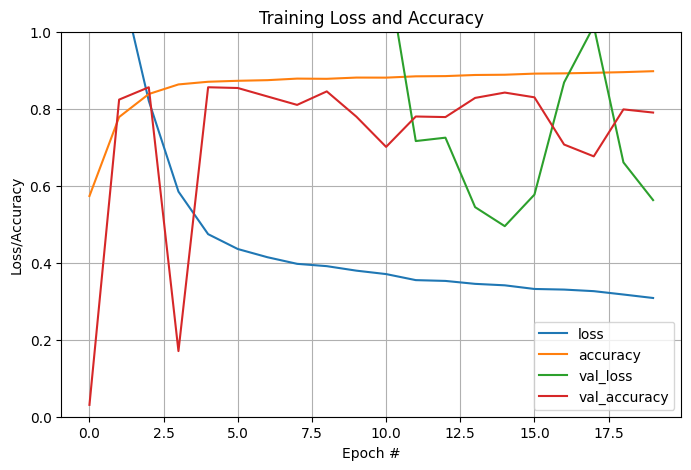

In [ ]:
# @title In đường cong học tập
print(H_segnet.history.keys())
plt.figure()
pd.DataFrame(H_segnet.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
# plt.plot(H.history['accuracy'], label="train_acc")
# plt.plot(H.history['val_accuracy'], label="val_acc")
# plt.plot(H.history['loss'], label = "train_loss")
# plt.plot(H.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()
plt.show()

#FCN

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization


# Định nghĩa mô hình FCN
def fcn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decoder
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    merge1 = tf.keras.layers.concatenate([conv3, up1], axis=-1)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    merge2 = tf.keras.layers.concatenate([conv2, up2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    merge3 = tf.keras.layers.concatenate([conv1, up3], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model
# Tạo mô hình FCN
input_shape = X_train.shape[1:]
num_classes = NCLASSES
model_fcn = fcn(input_shape, num_classes)
model_fcn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:

# Định nghĩa hàm tf_data
def tf_data(X_train, Y_train, X_val, Y_val, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train,
                                                   Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val,
                                                 Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds

In [10]:


# Tinh chỉnh siêu tham số
batch_size = 16
epochs = 20

# Callback
cb = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

# Fit model
train_ds, val_ds = tf_data(X_train, Y_train, X_valid, Y_valid, batch_size)
history = model_fcn.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=cb)

# Lưu mô hình
save_dir = os.path.join(os.getcwd(), 'trained_models')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'fcn_best_model.h5')
model_fcn.save(save_path)


Epoch 1/20
38/38 [==============================] - 40s 462ms/step - loss: 1.5568 - accuracy: 0.5589 - val_loss: 71.6721 - val_accuracy: 0.0234
Epoch 2/20
38/38 [==============================] - 11s 286ms/step - loss: 1.2468 - accuracy: 0.7927 - val_loss: 12.3693 - val_accuracy: 0.2840
Epoch 3/20
38/38 [==============================] - 11s 296ms/step - loss: 0.9899 - accuracy: 0.8430 - val_loss: 2.6485 - val_accuracy: 0.6327
Epoch 4/20
38/38 [==============================] - 11s 286ms/step - loss: 0.7298 - accuracy: 0.8623 - val_loss: 2.2792 - val_accuracy: 0.3825
Epoch 5/20
38/38 [==============================] - 11s 287ms/step - loss: 0.5666 - accuracy: 0.8687 - val_loss: 0.7864 - val_accuracy: 0.8147
Epoch 6/20
38/38 [==============================] - 11s 288ms/step - loss: 0.4797 - accuracy: 0.8709 - val_loss: 1.7891 - val_accuracy: 0.3895
Epoch 7/20
38/38 [==============================] - 11s 289ms/step - loss: 0.4386 - accuracy: 0.8736 - val_loss: 0.7323 - val_accuracy: 0.85

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


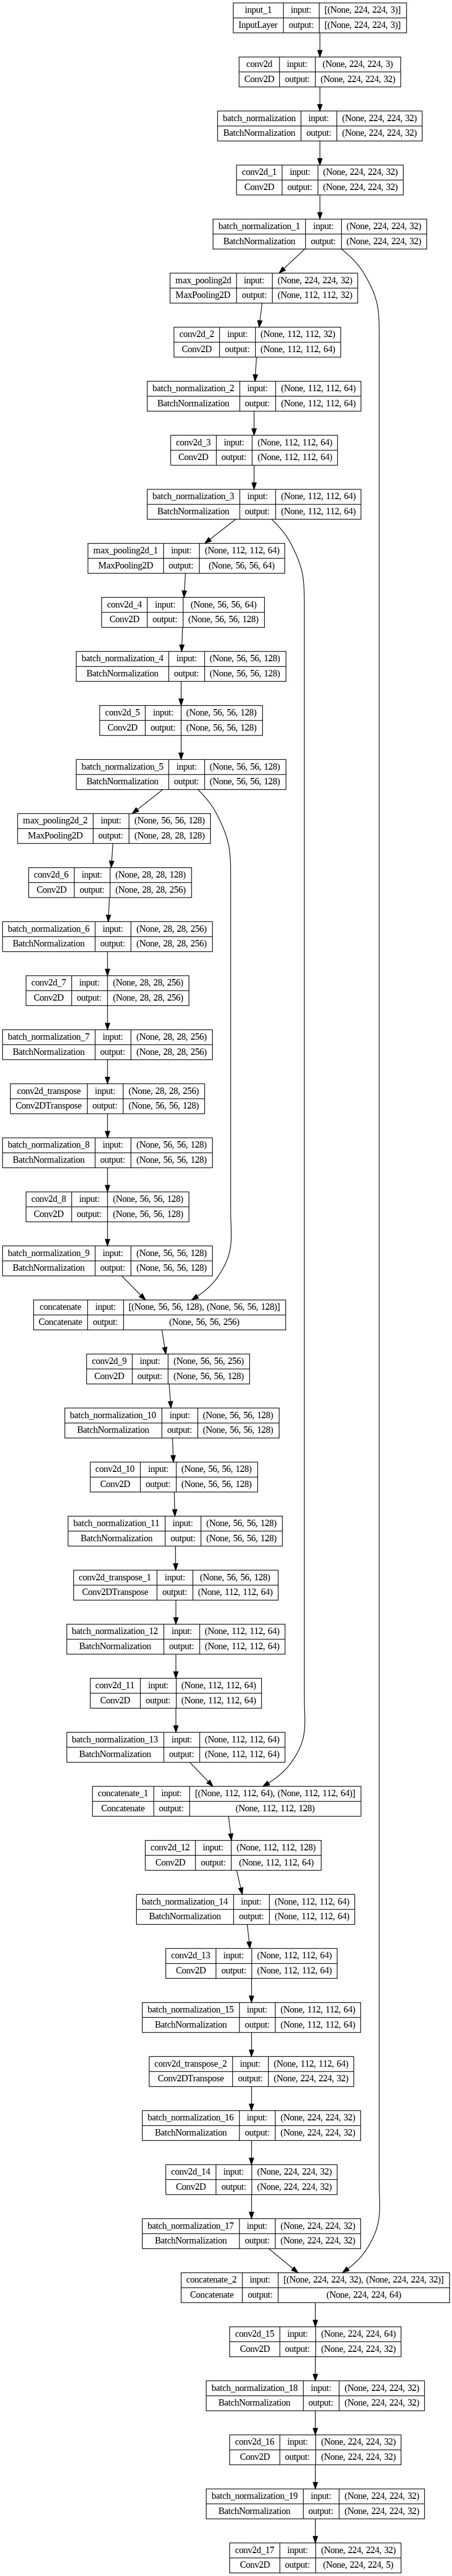

In [11]:
from keras.utils import plot_model
plot_model(model_fcn,"FCN.png",show_shapes=True)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 640x480 with 0 Axes>

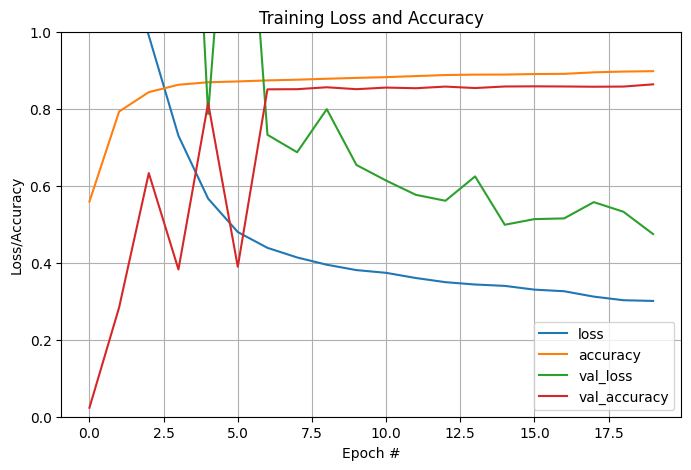

In [12]:
# @title In đường cong học tập
print(history.history.keys())
plt.figure()
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
# plt.plot(H.history['accuracy'], label="train_acc")
# plt.plot(H.history['val_accuracy'], label="val_acc")
# plt.plot(H.history['loss'], label = "train_loss")
# plt.plot(H.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()
plt.show()

#Unet

In [ ]:
# -*- coding: utf-8 -*-
"""U-Net.model

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1U1Kg42Lo4cD4dlyTMQnBjh3mBRP5oaS7
"""

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.layers import Activation, Concatenate

def conv_block(input, num_filters, block_name):
  x = Conv2D(num_filters, 3, padding='same',name=block_name+'_conv1')(input)
  x = BatchNormalization(name=block_name+'_norm1')(x)
  x = Activation('relu', name=block_name+'_act1')(x)

  x = Conv2D(num_filters, 3,padding='same',name=block_name+'_conv2')(x)
  x = BatchNormalization(name=block_name+'_norm2')(x)
  x = Activation('relu', name=block_name+'_act2')(x)

  return x


def encoder_block(input, num_filters, block_name:str,dropout_rate:float = None):
  s = conv_block(input, num_filters, block_name)
  p = MaxPool2D((2,2),name=block_name+'_pool')(s)
  if dropout_rate:
    p = Dropout(dropout_rate)(p)

  return s, p


def decoder_block(input, skip_features: list, num_filters, block_name:str, dropout_rate:float = None):
  d = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same', name=block_name+'_conv')(input)
  d = Concatenate(name=block_name+'_cat')([d, *skip_features])
  if dropout_rate:
    d = Dropout(dropout_rate)(d)
  d = conv_block(d, num_filters, block_name)

  return d

def Unet(input_shape, output_classes = 1, dropout_rate = None, base_filter=64):
  bf = base_filter
  filters = [bf, bf*2, bf*4, bf*8, bf*16]

  inputs= Input(shape = input_shape, name='Main Input')

  # encoder
  s1, p1 = encoder_block(inputs, filters[0], 'En_1', dropout_rate)
  s2, p2 = encoder_block(p1, filters[1], 'En_2', dropout_rate)
  s3, p3 = encoder_block(p2, filters[2], 'En_3', dropout_rate)
  s4, p4 = encoder_block(p3, filters[3], 'En_4', dropout_rate)

  # bridge
  b1 = conv_block(p4, filters[4], 'Bottleneck')

  # decoder
  d1 = decoder_block(b1, [s4], filters[3], 'De_1', dropout_rate)
  d2 = decoder_block(d1, [s3], filters[2], 'De_2', dropout_rate)
  d3 = decoder_block(d2, [s2], filters[1], 'De_3', dropout_rate)
  d4 = decoder_block(d3, [s1], filters[0], 'De_4', dropout_rate)

  outputs = Conv2D(output_classes, 1, padding='same', activation='softmax')(d4)

  model = Model(inputs, outputs, name='U-Net')
  return model


In [ ]:
# Load model
input_shape = X_train.shape[1:]
'''
Mô hình Unet nhận vào các tham số bắt buộc: input_shape, output_classes
Tham số tùy chỉnh: dropout_rate
'''
model = Unet(input_shape,NCLASSES, dropout_rate=0.3)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Main Input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 En_1_conv1 (Conv2D)         (None, 224, 224, 64)         1792      ['Main Input[0][0]']          
                                                                                                  
 En_1_norm1 (BatchNormaliza  (None, 224, 224, 64)         256       ['En_1_conv1[0][0]']          
 tion)                                                                                            
                                                                                                  
 En_1_act1 (Activation)      (None, 224, 224, 64)         0         ['En_1_norm1[0][0]']      

In [ ]:
# Chuyển dữ liệu về format tf.data

def tf_data(X_train, Y_train, X_val, Y_val, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train,
                                                   Y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val,
                                                 Y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds

In [ ]:

# Tinh chỉnh siêu tham số
batch_size = 16
epochs = 20

# Callback
cb = [EarlyStopping(monitor='val_loss', patience=5,
                    restore_best_weights=True)]

train_ds, val_ds = tf_data(X_train, Y_train, X_valid, Y_valid, batch_size)

H = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs, callbacks = cb
)

# Save model
save_dir = os.path.join(os.getcwd(), 'trained_models')
if (not os.path.exists(save_dir)):
  os.makedirs(save_dir)

save_path = os.path.join(save_dir,'unet.best_model.keras')
model.save(save_path)

Epoch 1/20
38/38 [==============================] - 99s 1s/step - loss: 0.9321 - accuracy: 0.7580 - val_loss: 12806.7598 - val_accuracy: 0.0715
Epoch 2/20
38/38 [==============================] - 36s 955ms/step - loss: 0.5396 - accuracy: 0.8690 - val_loss: 3.4471 - val_accuracy: 0.6003
Epoch 3/20
38/38 [==============================] - 36s 955ms/step - loss: 0.5125 - accuracy: 0.8699 - val_loss: 0.6114 - val_accuracy: 0.8557
Epoch 4/20
38/38 [==============================] - 36s 949ms/step - loss: 0.5031 - accuracy: 0.8699 - val_loss: 0.6219 - val_accuracy: 0.8558
Epoch 5/20
38/38 [==============================] - 36s 952ms/step - loss: 0.4964 - accuracy: 0.8698 - val_loss: 0.6166 - val_accuracy: 0.8558
Epoch 6/20
38/38 [==============================] - 36s 953ms/step - loss: 0.4900 - accuracy: 0.8701 - val_loss: 0.5916 - val_accuracy: 0.8558
Epoch 7/20
38/38 [==============================] - 36s 951ms/step - loss: 0.4828 - accuracy: 0.8696 - val_loss: 0.5994 - val_accuracy: 0.855

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 640x480 with 0 Axes>

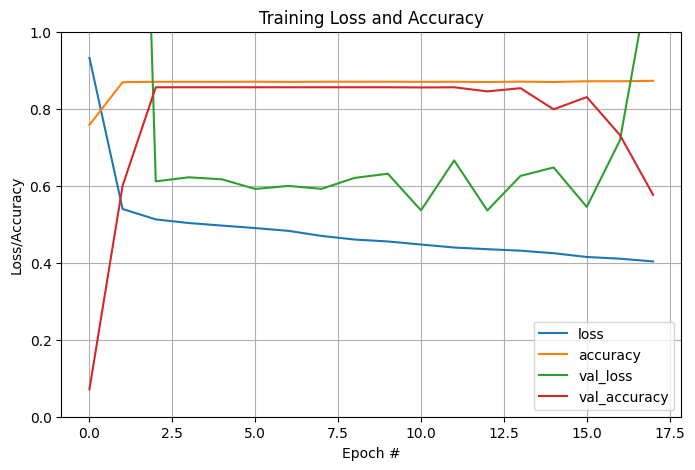

In [ ]:

# @title In đường cong học tập
print(H.history.keys())
plt.figure()
pd.DataFrame(H.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
# plt.plot(H.history['accuracy'], label="train_acc")
# plt.plot(H.history['val_accuracy'], label="val_acc")
# plt.plot(H.history['loss'], label = "train_loss")
# plt.plot(H.history['val_loss'], label = "val_loss")
plt.title('Training Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch #')
plt.legend()
plt.show()